In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.21.6', '1.13.1+cu116')

In [3]:
import matplotlib
matplotlib.__version__

'3.2.2'

## 1. Load Data

In [4]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [5]:
# 1. tokenize

corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [6]:
# 2. numericalize
# 2.1 get all the unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))
vocabs

['fruit', 'cat', 'dog', 'banana', 'animal', 'apple']

In [7]:
# 2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}
word2index

{'fruit': 0, 'cat': 1, 'dog': 2, 'banana': 3, 'animal': 4, 'apple': 5}

In [8]:
word2index['dog']

2

In [9]:
# add <UNK>
vocabs.append('<UNK>')

In [10]:
word2index['<UNK>'] = 6

In [11]:
word2index

{'fruit': 0,
 'cat': 1,
 'dog': 2,
 'banana': 3,
 'animal': 4,
 'apple': 5,
 '<UNK>': 6}

In [12]:
# create index2word dictionary
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'fruit',
 1: 'cat',
 2: 'dog',
 3: 'banana',
 4: 'animal',
 5: 'apple',
 6: '<UNK>'}

In [13]:
index2word[1]

'cat'

## 2. Prepare Train Data

In [14]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams
        
#here we want to create (banana, apple), (banana, fruit) append to some list

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog']]

In [15]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [16]:
random_batch(10, corpus_tokenized)

(array([[1],
        [5],
        [2],
        [5],
        [0],
        [2],
        [4],
        [0],
        [4],
        [3]]), array([[4],
        [0],
        [1],
        [3],
        [5],
        [4],
        [1],
        [3],
        [2],
        [5]]))

In [17]:
input, label = random_batch(2, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[2],
       [0]])
label=array([[1],
       [3]])


In [18]:
input, label = random_batch(1, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[2]])
label=array([[1]])


In [19]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[3],
       [3],
       [4],
       [5],
       [1],
       [0],
       [2],
       [5],
       [4],
       [2]])


## 3. Model

In [20]:
voc_size = len(vocabs)
voc_size

7

In [21]:
vocabs

['fruit', 'cat', 'dog', 'banana', 'animal', 'apple', '<UNK>']

In [22]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
      
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [23]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 7])

In [24]:
voc_size

7

In [25]:
input, label = random_batch(1, corpus_tokenized)
input #center word

array([[5]])

In [26]:
label #context word

array([[3]])

In [168]:
voc_size

7

In [27]:
emb_size = 2 #usually, this can be 50, 100, or 300
model = Skipgram(voc_size, emb_size)

In [28]:
input_tensor = torch.LongTensor(input)
label_tensor = torch.LongTensor(label)  #LongTensor basically means integer....

In [29]:
input_tensor.shape

torch.Size([1, 1])

In [30]:
label_tensor.shape

torch.Size([1, 1])

In [172]:
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6]])

In [113]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [114]:
loss

tensor(4.1062, grad_fn=<NegBackward0>)

In [50]:
# center_word_embedding = model(input_tensor, label_tensor)
# center_word_embedding.shape #(batch_size, 1, emb_size)

torch.Size([1, 1, 2])

## 4. Training

In [31]:
batch_size = 2
emb_size = 2
model = Skipgram(voc_size, emb_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [33]:
num_epochs = 1000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(input_batch)

    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 100 | Loss: 0.375253 | Time: ??
Epoch 200 | Loss: 1.789473 | Time: ??
Epoch 300 | Loss: 0.218259 | Time: ??
Epoch 400 | Loss: 0.156426 | Time: ??
Epoch 500 | Loss: 0.963335 | Time: ??
Epoch 600 | Loss: 1.750512 | Time: ??
Epoch 700 | Loss: 0.911892 | Time: ??
Epoch 800 | Loss: 0.103424 | Time: ??
Epoch 900 | Loss: 0.900822 | Time: ??
Epoch 1000 | Loss: 0.134583 | Time: ??


## 5. Plot the Embeddings

In [34]:
vocabs

['fruit', 'cat', 'dog', 'banana', 'animal', 'apple', '<UNK>']

In [35]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([3])

In [36]:
banana_center_embed = model.embedding_center_word(banana)
banana_outisde_embed = model.embedding_outside_word(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[-0.4609, -3.0112]], grad_fn=<DivBackward0>)

In [37]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [38]:
#find embedding of fruit, cat
print(get_embed('fruit'))
print(get_embed('cat'))

print(get_embed('chaky'))

(-2.5643861293792725, -0.4012210965156555)
(2.181389331817627, 2.1800904273986816)
(0.40432682633399963, 0.1158939003944397)


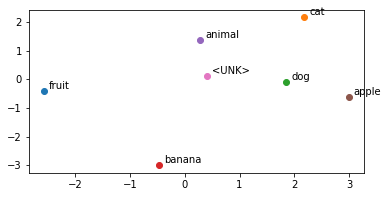

In [39]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## How to Tokenize Sentence

In [40]:
import spacy
spacy.__version__

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'3.4.4'

In [41]:
nlp = spacy.load("en_core_web_sm")

# for stronger code, we can use en_core_web_med, 

In [42]:
text = "Chaky loves to eat sushi."

In [43]:
for token in nlp(text):
  print(token)

Chaky
loves
to
eat
sushi
.


In [46]:
tokens = nlp(text)

In [47]:
tokens

Chaky loves to eat sushi.

In [48]:
text = "Chaky teaches up-to-date NLP, which gives $@'"

In [49]:
for token in nlp(text):
  print(token)

Chaky
teaches
up
-
to
-
date
NLP
,
which
gives
$
@
'


In [50]:
tokens = nlp(text)

In [51]:
tokens

Chaky teaches up-to-date NLP, which gives $@'